In [1]:
import wandb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss,mean_squared_error, r2_score, classification_report

## Data Loading

In [33]:
data = pd.read_csv('HousingData.csv')

data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


## 3.1 Data Preprocessing

### 3.1.1

In [34]:
table = pd.DataFrame({
    "Mean": data.drop(['MEDV'], axis=1).mean().values,
    "Standard Deviation": data.drop(['MEDV'], axis=1).std().values,
    "Minimum": data.drop(['MEDV'], axis=1).min().values,
    "Maximum": data.drop(['MEDV'], axis=1).max().values,
}, index=data.drop(['MEDV'], axis=1).columns)

table

,Mean,Standard Deviation,Minimum,Maximum
CRIM,3.611874,8.720192,0.00632,88.9762
ZN,11.211934,23.388876,0.00000,100.0000
INDUS,11.083992,6.835896,0.46000,27.7400
CHAS,0.069959,0.255340,0.00000,1.0000
NOX,0.554695,0.115878,0.38500,0.8710
RM,6.284634,0.702617,3.56100,8.7800
AGE,68.518519,27.999513,2.90000,100.0000
DIS,3.795043,2.105710,1.12960,12.1265
RAD,9.549407,8.707259,1.00000,24.0000
TAX,408.237154,168.537116,187.00000,711.0000


### 3.1.2

In [35]:
missing = data.isnull().any().any()

missing

True

In [36]:
data = data.fillna(data.mean())

### 3.1.3

In [37]:
X, y = data.drop(['MEDV'], axis=1), (data['MEDV']).values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

### 3.1.4

## 3.2  MLP Regression Implementation from Scratch

In [39]:
class MLPRegressor:
    def __init__(self, layers, epochs=100, batch_size=32, activation='sigmoid', optimiser='sgd', alpha=0.01):
        self.layers = layers
        self.alpha = alpha
        self.epochs = epochs
        self.batch_size = batch_size if optimiser == 'mini-batch' else None
        self.activations = {
            'sigmoid': self.sigmoid,
            'tanh': self.tanh,
            'relu': self.relu,
            'identity': self.identity,
        }
        self.optimisers = {
            'sgd': self._sgd,
            'batch': self._batch_gd,
            'mini-batch': self._mini_batch_gd
        }
        self.activation = self.activations[activation]
        self.optimiser = self.optimisers[optimiser]

    def _forward(self, X):
        self.a = [X]
        self.z = []
        for w in self.weights:
            z = np.dot(self.a[-1], w)
            a = self.activation(z)
            self.z.append(z)
            self.a.append(a)
        self.a.pop()
        self.a.append(self.z[-1])
        return self.a[-1]

    def _back(self, X, y):
        dz = self.loss(y, self.a[-1], derivative=True)
        dw = np.dot(self.a[-2].T, dz)
        gradients = [dw]
        
        for i in range(len(self.weights) - 2, -1, -1):
            dz = np.dot(dz, self.weights[i + 1].T) * self.activation(self.a[i + 1], derivative=True)
            dw = np.dot(self.a[i].T, dz)
            gradients.insert(0, dw)
        
        return gradients
    
    def _sgd(self, X, y):
        for i in range(X.shape[0]):  
            xi = X[i].reshape(1, -1) 
            yi = y[i].reshape(1, -1)  

            y_hat = self._forward(xi)
            gradients = self._back(xi, yi)

            for j, gradient in enumerate(gradients):
                self.weights[j] -= self.alpha * gradient

    def _batch_gd(self, X, y):
        y_hat = self._forward(X)
        gradients = self._back(X, y)
        for i, gradient in enumerate(gradients):
            gradient = np.mean(gradient, axis=0)
            self.weights[i] -= self.alpha * gradient
            
    def _get_mini_batches(self, X, y, batch_size):
        m = X.shape[0]
        indices = np.arange(m)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # Change this
        for i in range(0, m, batch_size):
            yield (X_shuffled[i:i + batch_size], y_shuffled[i:i + batch_size])
    
    def _mini_batch_gd(self, X, y):
        for X_mini, y_mini in self._get_mini_batches(X, y, self.batch_size):
            y_hat = self._forward(X_mini)
            gradients = self._back(X_mini, y_mini)

            for j, gradient in enumerate(gradients):
                self.weights[j] -= self.alpha * gradient
    
    def _initialize_weights(self, inp, out, seed):
        np.random.seed(seed)
        self.layers = (inp, ) + tuple(self.layers) + (out, )
        weights = []
        for i in range(1, len(self.layers)):
            w = np.random.randn(self.layers[i - 1], self.layers[i])
            weights.append(w)
        return weights
    
    def train(self, X, y, val_data, losses, seed):
        self.weights = self._initialize_weights(X.shape[1], y.shape[1], seed)
        size = len(X) if self.batch_size == None else self.batch_size
        for ep in range(1, self.epochs + 1):
            self.optimiser(X, y)
            loss, val_loss, mse, rmse, r_s = self.get_vals(X, y, val_data)
            data_log = {
                "ep_loss": loss,
                "ep_val_loss": val_loss,
                "ep_mse": mse,
                "ep_rmse": rmse,
                "ep_r_s": r_s,
            }
#             wandb.log(data_log)
            losses.append(mse)
#             print(f"Epoch {ep}/{self.epochs}\n{size}/{size} - loss: {loss:.4f} - val_loss: {val_loss:.4f} - mse: {mse:.4f} - rmse: {rmse:.4f} - r_s: {r_s:.4f}")
          
    def get_vals(self, X, y, val_data):
        yHat = self.predict(X)
        yHat_val = self.predict(val_data[0])
        mse = mean_squared_error(val_data[1], yHat_val)
        rmse = np.sqrt(mse)
        r_s = r2_score(val_data[1], yHat_val)
        return self.loss(y, yHat), self.loss(val_data[1], yHat_val), mse, rmse, r_s 
    
    def loss(self, a, b, derivative=False):
        if derivative:
            return -1 * (a - b)
        return np.sum((a - b) ** 2) / (2 * len(a))
    
    def predict(self, X):
        return self._forward(X) 
    
    def sigmoid(self, z, derivative=False):
        if derivative:
            return z * (1 - z)
        return 1 / (1 + np.exp(-z))

    def tanh(self, z, derivative=False):
        if derivative:
            return 1.0 - z ** 2
        return np.tanh(z)
    
    def identity(self, z, derivative=False):
            if derivative:
                return 1
            return z
    
    def relu(self, z, derivative=False):
        if derivative:
            return np.where(z > 0, 1, 0)
        return np.maximum(0, z)

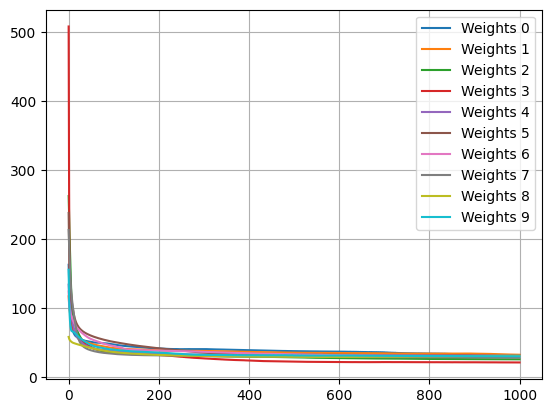

In [43]:
losses = []
k = 10
for i in (np.random.rand(k) * 100).astype(int):
    ls = []
    model = MLPRegressor(layers=(12,5,3,9,7,), activation='relu', epochs=1000, alpha=1e-5, optimiser='sgd')
    model.train(X_train_std, y_train, (X_val_std, y_val), ls, i)
    losses.append(ls)

for i in range(k):
    plt.plot(np.linspace(0, 1000, 1000), losses[i], label='Weights ' + str(i))

plt.legend()
plt.grid(True)
plt.show()